In [1]:
from geometry import *
import numpy as np
import pypower
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

def make_power(X,w):
    A = np.array([[ 0, 0, 1],
                  [ 0, 0,-1],
                  [ 0, 1, 0],
                  [ 0,-1, 0],
                  [ 1, 0, 0],
                  [-1, 0, 0]])
    b = np.array([100,100,1,1,1,1])
    return pypower.power_diagram(X,w,A,b)

# X=(x,y,z) is above the graph of (x,y) -> sqrt(|(x,y)-p|^2 + beta**2) + b_i
# <=> z >= sqrt((x-px)^2 + (y-py)^2 + beta**2) + b_i
# <=> (z-b_i)^2 >= (x-px)^2 + (y-py)^2 + beta**2 (AND z>=b_i...)
# <=> <Q(X-R)|(X-R)> - beta**2 >= 0 and z-b_i>=0
# with Q = diag(-1,-1,1), R = (px,py,bi)
# <=> <QX|X> - 2<QR|X> + <QR|R> - beta**2 >= 0

def make_hyperboloid(p, bi, beta):
    Q = np.array([-1,-1,1])
    R = np.array([p[0],p[1],bi])
    return Quadric(Q,b=-2*Q*R,c=np.dot(Q*R,R) - beta**2,
                   truncating_plane=True,p=np.array([0,0,1]),d=-bi)

def make_laguerre(Y, psi, beta, k=20):
    assert(all(psi > 0))
    N = len(Y)
    X = np.zeros((N,3))
    X[:,0:2] = Y
    X[:,2] = -psi
    w = 2*psi**2
    
    cells = make_power(X,w)
    curves = []
    for i in range(N):
        quad = make_hyperboloid(Y[i], psi[i], beta)
        c = intersect_cell_with_quadric(X,cells[i],quad,k)
        curves.append(c)
    return curves

def plot_laguerre_cell(curves):
    area = 0
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for i in range(crv.shape[0]-1):
                a = crv[i,0:2]
                b = crv[i+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
            plt.plot(crv[:,0], crv[:,1], '.k')
    return area

def plot_laguerre(allcurves):
    areas = []
    for curves in allcurves:
        area = plot_laguerre_cell(curves)
        areas.append(area)
    return areas

def nabla_y_cost(x,y,beta):
    return (y-x)/ np.sqrt(np.linalg.norm(x-y)**2 + beta**2)

def compute_H_DH_from_laguerre(Y, beta, allcurves):
    areas = []
    N = len(allcurves)
    areas = np.zeros(N)
    DH = np.zeros((N,N))
    for i in range(N):
        curves = allcurves[i]
        for j,curvesj in curves.items():
            for crv in curvesj:
                crv = np.array(crv)
                for k in range(crv.shape[0]-1):
                    a = crv[k,0:2]
                    b = crv[k+1,0:2]
                    areas[i] += np.linalg.det(np.array([a,b]))/2
                    if j<0:
                        continue
                    length  = np.linalg.norm(b-a)
                    x = (a+b)/2
                    hij = length/np.linalg.norm(nabla_y_cost(x,Y[i],beta) - nabla_y_cost(x,Y[j],beta))
                    DH[i,j] += hij
                    DH[i,i] -= hij
    return np.array(areas), DH

[0.3803816375910541, 0.3721527592826285, 0.32627204576293156, 0.49569929118083683, 0.5563044152818566, 0.39651592813933384, 0.49052927397599694, 0.43635759468749075, 0.2662492017965921, 0.2795378520363981]
3.9999999997351194
1.168863885237676e-12


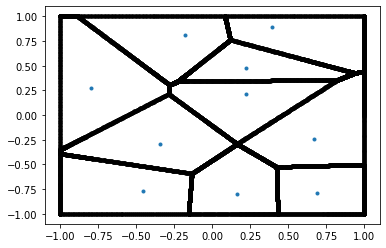

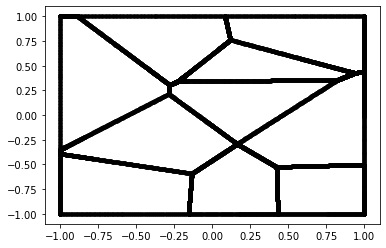

In [74]:
N = 10
Y = 2*(np.random.rand(N,2)-.5)
psi = 0.001*np.random.rand(N)
beta = 1
curves = make_laguerre(Y, psi, beta,k=100)

plt.figure()
areas = plot_laguerre(curves)
plt.plot(Y[:,0],Y[:,1],'.')
print(areas)
print(np.sum(areas))


psi += .5
curves = make_laguerre(Y, psi, beta, k=100)
plt.figure()
areas2 = plot_laguerre(curves)
print(np.linalg.norm(np.array(areas)-np.array(areas2))/N)

In [75]:
def check_gradient(f,gradf,x0):
    N = len(x0)
    gg = np.zeros((N,N))
    for i in range(N):
        eps = 1e-3
        e = np.zeros(N)
        e[i] = eps
        gg[i,:] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numérique dans le calcul du gradient: %g (doit être petit)' % np.linalg.norm(gradf(x0)-gg))
    print(gradf(x0))
    print(gg)
    
N = 5
Y = 2*(np.random.rand(N,2)-.5)
beta = 1

H = lambda psi: compute_H_DH_from_laguerre(Y,beta,make_laguerre(Y, psi, beta, k=100))[0]
DH = lambda psi: compute_H_DH_from_laguerre(Y,beta,make_laguerre(Y, psi, beta, k=100))[1]

psi = 0.11*np.ones(N)
np.set_printoptions(2)
check_gradient(H,DH,psi)

erreur numérique dans le calcul du gradient: 2.87388e-05 (doit être petit)
[[-2.63  0.    0.    0.87  1.75]
 [ 0.   -2.2   0.88  1.32  0.  ]
 [ 0.    0.88 -2.96  0.54  1.55]
 [ 0.87  1.32  0.54 -3.56  0.82]
 [ 1.75  0.    1.55  0.82 -4.12]]
[[-2.63e+00  5.00e-12  5.77e-12  8.75e-01  1.75e+00]
 [-2.78e-13 -2.20e+00  8.79e-01  1.32e+00  3.77e-12]
 [ 0.00e+00  8.79e-01 -2.96e+00  5.35e-01  1.55e+00]
 [ 8.75e-01  1.32e+00  5.35e-01 -3.56e+00  8.25e-01]
 [ 1.75e+00  1.05e-12  1.55e+00  8.25e-01 -4.12e+00]]


In [4]:
N = 1000
psi = 0.11*np.ones(N)
Y = 2*(np.random.rand(N,2)-.5)
beta = 1

def H_DH(psi):
    lag = make_laguerre(Y, psi, beta, k=20)
    #plt.figure()
    #plot_laguerre(lag)
    #plt.show()
    return compute_H_DH_from_laguerre(Y,beta,lag)

h,dh = H_DH(psi)
for i in range(5):
    #print("%d -> " % i) 
    #print("H(psi) = ", h)
    #print("psi = ", psi)
    dh = dh[0:N-1,0:N-1]
    h = h[0:N-1]
    d = np.zeros(N)
    d[0:N-1] = -np.linalg.solve(dh, h - 4/N)
    print("it={}, error={}".format(i,np.linalg.norm(h - 4/N)))
    t = 1
    d = d - min(d)
    psi0 = psi.copy()
    while True:
        psi = psi0 + t*d
        h,dh = H_DH(psi)
        if min(h) > 0:
            #print(dh)
            print("t=%g"%t)
            break
        t = t/2
 

it=0, error=0.06611251922382022
t=1
it=1, error=0.02560008393222981
t=1
it=2, error=0.0022259761316704963
t=1
it=3, error=5.134095445917508e-05
t=1
it=4, error=5.7425113679417415e-08
t=1


volume of power cells = 800.0
area of 2D laguerre cells = 3.9999998332344457


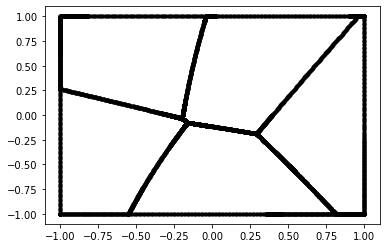

ev: 1.2750634273732158
z: 1.2750634273732135
-4.440892098500626e-15
ev: 1.2689979243756078
z: 1.2689979243756078
4.440892098500626e-16
ev: 1.2630385174878103
z: 1.2630385174878105
0.0
ev: 1.257187069546445
z: 1.257187069546445
-2.220446049250313e-16
ev: 1.2514454508475947
z: 1.2514454508475945
0.0
ev: 1.245815537454782
z: 1.245815537454782
-2.220446049250313e-16
ev: 1.240299209410848
z: 1.2402992094108483
0.0
ev: 1.234898348853664
z: 1.234898348853664
4.440892098500626e-16
ev: 1.2296148380360759
z: 1.2296148380360759
2.220446049250313e-16
ev: 1.2244505572509725
z: 1.2244505572509723
-6.661338147750939e-16
ev: 1.2194073826628835
z: 1.2194073826628835
2.220446049250313e-16
ev: 1.214487184048075
z: 1.214487184048075
0.0
ev: 1.2096918224457074
z: 1.2096918224457076
2.220446049250313e-16
ev: 1.2050231477232156
z: 1.2050231477232156
0.0
ev: 1.2004829960597325
z: 1.2004829960597325
0.0
ev: 1.1960731873520265
z: 1.1960731873520265
2.220446049250313e-16
ev: 1.191795522548102
z: 1.19179552254810

-2.220446049250313e-16
ev: 1.4165058649717142
z: 1.4165058649717144
4.440892098500626e-16
ev: 1.4165058987028467
z: 1.416505898702847
2.220446049250313e-16
ev: 1.416505932433989
z: 1.4165059324339888
2.220446049250313e-16
ev: 1.4165059661651398
z: 1.41650596616514
4.440892098500626e-16
ev: 1.4165059998963003
z: 1.4165059998963005
2.220446049250313e-16
ev: 1.4165060336274702
z: 1.4165060336274702
-6.661338147750939e-16
ev: 1.4165060673586494
z: 1.4165060673586491
-4.440892098500626e-16
ev: 1.4165061010898379
z: 1.4165061010898377
0.0
ev: 1.4165061348210353
z: 1.4165061348210353
-6.661338147750939e-16
ev: 1.4165061685522424
z: 1.4165061685522422
-4.440892098500626e-16
ev: 1.4165062022834585
z: 1.4165062022834587
0.0
ev: 1.4165062360146843
z: 1.416506236014684
-2.220446049250313e-16
ev: 1.416506269745919
z: 1.416506269745919
-2.220446049250313e-16
ev: 1.416506303477163
z: 1.4165063034771632
4.440892098500626e-16
ev: 1.4165063372084163
z: 1.4165063372084166
2.220446049250313e-16
ev: 1.4165

0.0
ev: 1.3586915785861575
z: 1.3586915785861575
-2.220446049250313e-16
ev: 1.3580351034547307
z: 1.3580351034547304
0.0
ev: 1.3573804181556426
z: 1.3573804181556426
0.0
ev: 1.3567275254148163
z: 1.3567275254148166
2.220446049250313e-16
ev: 1.3560764279475945
z: 1.3560764279475945
6.661338147750939e-16
ev: 1.3554271284586572
z: 1.355427128458657
-2.220446049250313e-16
ev: 1.3547796296419432
z: 1.354779629641943
0.0
ev: 1.3541339341805676
z: 1.3541339341805674
-2.220446049250313e-16
ev: 1.3534900447467417
z: 1.3534900447467417
2.220446049250313e-16
ev: 1.3528479640016924
z: 1.3528479640016924
-2.220446049250313e-16
ev: 1.3522076945955814
z: 1.3522076945955819
6.661338147750939e-16
ev: 1.3515692391674254
z: 1.3515692391674254
2.220446049250313e-16
ev: 1.3509326003450144
z: 1.3509326003450144
2.220446049250313e-16
ev: 1.350297780744833
z: 1.3502977807448329
-6.661338147750939e-16
ev: 1.3496647829719808
z: 1.3496647829719806
-6.661338147750939e-16
ev: 1.3490336096200903
z: 1.34903360962009

-2.220446049250313e-16
ev: 1.3420519267841509
z: 1.3420519267841509
0.0
ev: 1.3412743003015506
z: 1.3412743003015506
2.220446049250313e-16
ev: 1.340504018692441
z: 1.340504018692441
2.220446049250313e-16
ev: 1.3397411111001807
z: 1.339741111100181
6.661338147750939e-16
ev: 1.3389856064588535
z: 1.3389856064588537
4.440892098500626e-16
ev: 1.3382375334885541
z: 1.338237533488554
-2.220446049250313e-16
ev: 1.3374969206906653
z: 1.337496920690665
-2.220446049250313e-16
ev: 1.3367637963431305
z: 1.3367637963431307
2.220446049250313e-16
ev: 1.3360381884957238
z: 1.3360381884957238
-2.220446049250313e-16
ev: 1.3353201249653122
z: 1.3353201249653122
2.220446049250313e-16
ev: 1.3346096333311213
z: 1.334609633331121
-2.220446049250313e-16
ev: 1.3339067409299976
z: 1.3339067409299976
-2.220446049250313e-16
ev: 1.3332114748516757
z: 1.333211474851676
2.220446049250313e-16
ev: 1.3325238619340434
z: 1.3325238619340432
-4.440892098500626e-16
ev: 1.3318439287584138
z: 1.3318439287584136
-6.6613381477

-2.220446049250313e-16
ev: 1.4021341435176318
z: 1.4021341435176318
0.0
ev: 1.4023808617861824
z: 1.4023808617861824
2.220446049250313e-16
ev: 1.4026278481621546
z: 1.4026278481621544
-2.220446049250313e-16
ev: 1.402875102398534
z: 1.402875102398534
-2.220446049250313e-16
ev: 1.4031226242480588
z: 1.4031226242480588
2.220446049250313e-16
ev: 1.4033704134632186
z: 1.4033704134632188
4.440892098500626e-16
ev: 1.4036184697962586
z: 1.4036184697962584
0.0
ev: 1.4038667929991786
z: 1.4038667929991786
-2.220446049250313e-16
ev: 1.4041153828237367
z: 1.4041153828237367
2.220446049250313e-16
ev: 1.4043642390214481
z: 1.4043642390214484
2.220446049250313e-16
ev: 1.4046133613435892
z: 1.404613361343589
-2.220446049250313e-16
ev: 1.4048627495411958
z: 1.4048627495411956
0.0
ev: 1.405112403365067
z: 1.405112403365067
-2.220446049250313e-16
ev: 1.4053623225657668
z: 1.4053623225657665
2.220446049250313e-16
ev: 1.4056125068936214
z: 1.4056125068936214
-4.440892098500626e-16
ev: 1.4058629560987272
z:

ev: 1.40551930207529
z: 1.4055193020752899
0.0
ev: 1.405396343247185
z: 1.4053963432471852
2.220446049250313e-16
ev: 1.4052736295747241
z: 1.4052736295747241
-2.220446049250313e-16
ev: 1.405151161116196
z: 1.4051511611161958
-2.220446049250313e-16
ev: 1.405028937929627
z: 1.4050289379296272
4.440892098500626e-16
ev: 1.4049069600727826
z: 1.4049069600727826
0.0
ev: 1.4047852276031647
z: 1.4047852276031647
2.220446049250313e-16
ev: 1.404663740578013
z: 1.4046637405780131
4.440892098500626e-16
ev: 1.4045424990543043
z: 1.4045424990543043
-2.220446049250313e-16
ev: 1.4044215030887526
z: 1.4044215030887526
2.220446049250313e-16
ev: 1.4043007527378077
z: 1.4043007527378077
2.220446049250313e-16
ev: 1.4041802480576564
z: 1.4041802480576564
-2.220446049250313e-16
ev: 1.4040599891042218
z: 1.404059989104222
0.0
ev: 1.4039399759331626
z: 1.4039399759331628
0.0
ev: 1.4038202085998734
z: 1.4038202085998732
-2.220446049250313e-16
ev: 1.4037006871594833
z: 1.4037006871594833
-4.440892098500626e-16
e

-6.661338147750939e-16
ev: 1.528839792877228
z: 1.528839792877228
4.440892098500626e-16
ev: 1.528839851524644
z: 1.528839851524644
0.0
ev: 1.5288399101720633
z: 1.5288399101720636
4.440892098500626e-16
ev: 1.528839968819486
z: 1.528839968819486
4.440892098500626e-16
ev: 1.5288400274669118
z: 1.528840027466912
4.440892098500626e-16
ev: 1.528840086114341
z: 1.528840086114341
2.220446049250313e-16
ev: 1.5288401447617732
z: 1.5288401447617734
0.0
ev: 1.528840203409209
z: 1.528840203409209
0.0
ev: 1.528840262056648
z: 1.5288402620566481
1.1102230246251565e-15
ev: 1.52884032070409
z: 1.52884032070409
-2.220446049250313e-16
ev: 1.5288403793515353
z: 1.5288403793515355
6.661338147750939e-16
ev: 1.5288404379989837
z: 1.528840437998984
8.881784197001252e-16
ev: 1.5288404966464357
z: 1.528840496646436
2.220446049250313e-16
ev: 1.5288405552938908
z: 1.5288405552938908
0.0
ev: 1.528840613941349
z: 1.5288406139413493
2.220446049250313e-16
ev: 1.5288406725888108
z: 1.5288406725888108
0.0
ev: 1.528840

2.220446049250313e-16
ev: 1.3620060137652246
z: 1.3620060137652246
2.220446049250313e-16
ev: 1.3691533952493777
z: 1.3691533952493775
-6.661338147750939e-16
ev: 1.3764007658041035
z: 1.3764007658041035
2.220446049250313e-16
ev: 1.3837447510466392
z: 1.3837447510466394
4.440892098500626e-16
ev: 1.391182001506828
z: 1.3911820015068281
4.440892098500626e-16
ev: 1.3987091973473373
z: 1.3987091973473371
-6.661338147750939e-16
ev: 1.4063230527153456
z: 1.4063230527153456
2.220446049250313e-16
ev: 1.414020319731704
z: 1.414020319731704
4.440892098500626e-16
ev: 1.4217977921255385
z: 1.4217977921255385
0.0
ev: 1.4296523085239368
z: 1.4296523085239368
4.440892098500626e-16
ev: 1.4375807554077864
z: 1.4375807554077866
4.440892098500626e-16
ev: 1.4455800697460188
z: 1.445580069746019
6.661338147750939e-16
ev: 1.453647241321456
z: 1.453647241321456
0.0
ev: 1.4617793147622014
z: 1.4617793147622016
4.440892098500626e-16
ev: 1.469973391293053
z: 1.469973391293053
4.440892098500626e-16
ev: 1.478226630

2.220446049250313e-16
ev: 1.5287443134571785
z: 1.5287443134571785
-6.661338147750939e-16
ev: 1.5287405644268148
z: 1.5287405644268148
2.220446049250313e-16
ev: 1.5287369587218314
z: 1.5287369587218314
0.0
ev: 1.5287334963444725
z: 1.5287334963444725
0.0
ev: 1.5287301772968669
z: 1.5287301772968669
-4.440892098500626e-16
ev: 1.5287270015810281
z: 1.5287270015810281
2.220446049250313e-16
ev: 1.5287239691988537
z: 1.528723969198854
0.0
ev: 1.5287210801521267
z: 1.5287210801521267
-4.440892098500626e-16
ev: 1.5287183344425146
z: 1.5287183344425146
0.0
ev: 1.5287157320715687
z: 1.528715732071569
4.440892098500626e-16
ev: 1.5287132730407262
z: 1.5287132730407262
0.0
ev: 1.528710957351308
z: 1.528710957351308
-2.220446049250313e-16
ev: 1.5287087850045198
z: 1.52870878500452
0.0
ev: 1.5287067560014524
z: 1.5287067560014527
2.220446049250313e-16
ev: 1.5287048703430808
z: 1.5287048703430808
0.0
ev: 1.5287031280302643
z: 1.5287031280302643
-4.440892098500626e-16
ev: 1.5287015290637476
z: 1.52870

2.220446049250313e-16
ev: 1.5288427758833916
z: 1.5288427758833913
-4.440892098500626e-16
ev: 1.528842775773582
z: 1.5288427757735823
4.440892098500626e-16
ev: 1.5288427756637728
z: 1.5288427756637728
-2.220446049250313e-16
ev: 1.5288427755539633
z: 1.5288427755539635
0.0
ev: 1.5288427754441543
z: 1.5288427754441543
2.220446049250313e-16
ev: 1.528842775334345
z: 1.528842775334345
0.0
ev: 1.5288427752245357
z: 1.5288427752245357
0.0
ev: 1.5288427751147264
z: 1.5288427751147267
4.440892098500626e-16
ev: 1.5288427750049174
z: 1.5288427750049174
0.0
ev: 1.5288427748951083
z: 1.5288427748951083
0.0
ev: 1.528842774785299
z: 1.5288427747852993
4.440892098500626e-16
ev: 1.5288427746754902
z: 1.5288427746754902
-2.220446049250313e-16
ev: 1.5288427745656812
z: 1.5288427745656812
0.0
ev: 1.5288427744558724
z: 1.5288427744558724
0.0
ev: 1.5288427743460633
z: 1.5288427743460633
2.220446049250313e-16
ev: 1.5288427742362545
z: 1.5288427742362547
0.0
ev: 1.5288427741264456
z: 1.5288427741264456
-4.440

-5.329070518200751e-15
ev: 1.4407596914821625
z: 1.4407596914821625
0.0
ev: 1.4403468295583037
z: 1.4403468295583037
0.0
ev: 1.4399457961901525
z: 1.4399457961901523
-4.440892098500626e-16
ev: 1.4395566279132348
z: 1.4395566279132348
0.0
ev: 1.439179360741116
z: 1.439179360741116
-2.220446049250313e-16
ev: 1.4388140301578096
z: 1.4388140301578098
2.220446049250313e-16
ev: 1.438460671110248
z: 1.438460671110248
2.220446049250313e-16
ev: 1.43811931800082
z: 1.4381193180008203
4.440892098500626e-16
ev: 1.4377900046799823
z: 1.4377900046799823
0.0
ev: 1.4374727644389365
z: 1.4374727644389367
8.881784197001252e-16
ev: 1.437167630002389
z: 1.4371676300023892
2.220446049250313e-16
ev: 1.4368746335213884
z: 1.4368746335213882
-8.881784197001252e-16
ev: 1.436593806566244
z: 1.436593806566244
0.0
ev: 1.4363251801195334
z: 1.4363251801195336
0.0
ev: 1.4360687845691968
z: 1.4360687845691966
-6.661338147750939e-16
ev: 1.435824649701726
z: 1.435824649701726
2.220446049250313e-16
ev: 1.43559280469544

0.0
ev: 1.5288956436384962
z: 1.5288956436384964
0.0
ev: 1.5288956120926753
z: 1.528895612092675
-4.440892098500626e-16
ev: 1.5288955805468556
z: 1.5288955805468556
-2.220446049250313e-16
ev: 1.5288955490010376
z: 1.5288955490010374
-6.661338147750939e-16
ev: 1.528895517455221
z: 1.5288955174552212
0.0
ev: 1.5288954859094062
z: 1.5288954859094064
2.220446049250313e-16
ev: 1.5288954543635929
z: 1.5288954543635929
0.0
ev: 1.5288954228177811
z: 1.528895422817781
-6.661338147750939e-16
ev: 1.528895391271971
z: 1.528895391271971
0.0
ev: 1.528895359726162
z: 1.528895359726162
-6.661338147750939e-16
ev: 1.528895328180355
z: 1.528895328180355
-2.220446049250313e-16
ev: 1.5288952966345495
z: 1.5288952966345495
-2.220446049250313e-16
ev: 1.5288952650887455
z: 1.5288952650887455
4.440892098500626e-16
ev: 1.5288952335429429
z: 1.5288952335429429
-4.440892098500626e-16
ev: 1.528895201997142
z: 1.528895201997142
0.0
ev: 1.5288951704513425
z: 1.5288951704513427
0.0
ev: 1.5288951389055447
z: 1.5288951

0.0
ev: 1.200819512439831
z: 1.2008195124398309
-4.440892098500626e-16
ev: 1.2005231912508239
z: 1.2005231912508236
0.0
ev: 1.2002340486813177
z: 1.2002340486813177
4.440892098500626e-16
ev: 1.1999520920384512
z: 1.1999520920384512
2.220446049250313e-16
ev: 1.1996773284875326
z: 1.1996773284875324
-2.220446049250313e-16
ev: 1.1994097650513098
z: 1.1994097650513096
-4.440892098500626e-16
ev: 1.199149408609255
z: 1.199149408609255
4.440892098500626e-16
ev: 1.1988962658968612
z: 1.198896265896861
4.440892098500626e-16
ev: 1.198650343504952
z: 1.198650343504952
4.440892098500626e-16
ev: 1.1984116478790048
z: 1.1984116478790048
4.440892098500626e-16
ev: 1.198180185318486
z: 1.198180185318486
2.220446049250313e-16
ev: 1.1979559619762012
z: 1.1979559619762012
4.440892098500626e-16
ev: 1.1977389838576589
z: 1.1977389838576586
-2.220446049250313e-16
ev: 1.197529256820446
z: 1.1975292568204463
6.661338147750939e-16
ev: 1.1973267865736208
z: 1.1973267865736208
2.220446049250313e-16
ev: 1.19713157

6.661338147750939e-16
ev: 1.256320392600932
z: 1.256320392600932
4.440892098500626e-16
ev: 1.2574988576262947
z: 1.2574988576262947
2.220446049250313e-16
ev: 1.2586876119832329
z: 1.2586876119832329
6.661338147750939e-16
ev: 1.2598866245809035
z: 1.2598866245809033
0.0
ev: 1.2610958641535466
z: 1.2610958641535466
2.220446049250313e-16
ev: 1.262315299264269
z: 1.262315299264269
6.661338147750939e-16
ev: 1.2635448983088207
z: 1.2635448983088207
6.661338147750939e-16
ev: 1.264784629519363
z: 1.264784629519363
0.0
ev: 1.2660344609682288
z: 1.2660344609682286
0.0
ev: 1.2672943605716698
z: 1.2672943605716698
4.440892098500626e-16
ev: 1.2685642960935963
z: 1.2685642960935963
2.220446049250313e-16
ev: 1.269844235149305
z: 1.2698442351493047
2.220446049250313e-16
ev: 1.2711341452091904
z: 1.2711341452091902
0.0
ev: 1.2724339936024502
z: 1.2724339936024502
2.220446049250313e-16
ev: 1.2737437475207711
z: 1.273743747520771
-2.220446049250313e-16
ev: 1.2750633740220014
z: 1.2750633740220012
-4.4408

ev: 1.166603363583578
z: 1.1666033635835777
-2.220446049250313e-16
ev: 1.167681065160246
z: 1.1676810651602458
2.220446049250313e-16
ev: 1.1688146649181435
z: 1.1688146649181432
-2.220446049250313e-16
ev: 1.1700039529883561
z: 1.170003952988356
4.440892098500626e-16
ev: 1.1712487114143804
z: 1.1712487114143801
0.0
ev: 1.1725487143192357
z: 1.1725487143192355
-4.440892098500626e-16
ev: 1.1739037280771385
z: 1.1739037280771383
-2.220446049250313e-16
ev: 1.1753135114894468
z: 1.1753135114894466
-2.220446049250313e-16
ev: 1.176777815964584
z: 1.1767778159645839
-2.220446049250313e-16
ev: 1.1782963857016429
z: 1.1782963857016429
2.220446049250313e-16
ev: 1.1798689578773744
z: 1.1798689578773744
0.0
ev: 1.1814952628362643
z: 1.1814952628362643
2.220446049250313e-16
ev: 1.1831750242833956
z: 1.1831750242833934
-4.884981308350689e-15
ev: 1.1831750242833956
z: 1.1831750242833934
-4.884981308350689e-15
ev: 1.183585955188131
z: 1.1835859551881307
4.440892098500626e-16
ev: 1.1839999497478684
z: 1.

-2.220446049250313e-16
ev: 1.2702767037525897
z: 1.2702767037525897
2.220446049250313e-16
ev: 1.2687821647610757
z: 1.2687821647610757
0.0
ev: 1.267338513454577
z: 1.267338513454577
0.0
ev: 1.2659459642971398
z: 1.26594596429714
6.661338147750939e-16
ev: 1.2646047255112807
z: 1.2646047255112807
4.440892098500626e-16
ev: 1.263314998941041
z: 1.263314998941041
0.0
ev: 1.2620769799181015
z: 1.2620769799181015
0.0
ev: 1.2608908571311475
z: 1.2608908571311475
2.220446049250313e-16
ev: 1.259756812498685
z: 1.259756812498685
0.0
ev: 1.258675021045501
z: 1.258675021045501
2.220446049250313e-16
ev: 1.257645650782952
z: 1.2576456507829519
0.0
ev: 1.2566688625932725
z: 1.2566688625932725
0.0
ev: 1.2557448101180815
z: 1.2557448101180813
0.0
ev: 1.2548736396512616
z: 1.2548736396512614
-4.440892098500626e-16
ev: 1.2540554900363876
z: 1.2540554900363874
0.0
ev: 1.253290492568861
z: 1.2532904925688608
-2.220446049250313e-16
ev: 1.2525787709029192
z: 1.252578770902919
2.220446049250313e-16
ev: 1.25192

0.0
ev: 1.3851794135468833
z: 1.3851794135468833
0.0
ev: 1.3846533448020004
z: 1.3846533448020004
2.220446049250313e-16
ev: 1.3841279021730202
z: 1.3841279021730204
8.881784197001252e-16
ev: 1.3836030866754543
z: 1.3836030866754538
-4.440892098500626e-16
ev: 1.3830788993254755
z: 1.383078899325475
-6.661338147750939e-16
ev: 1.3825553411399139
z: 1.3825553411399139
0.0
ev: 1.3820324131362522
z: 1.382032413136252
-2.220446049250313e-16
ev: 1.38151011633262
z: 1.38151011633262
2.220446049250313e-16
ev: 1.38098845174779
z: 1.3809884517477897
-2.220446049250313e-16
ev: 1.3804674204011722
z: 1.3804674204011722
0.0
ev: 1.3799470233128104
z: 1.3799470233128104
2.220446049250313e-16
ev: 1.3794272615033765
z: 1.379427261503376
-4.440892098500626e-16
ev: 1.3789081359941644
z: 1.3789081359941644
4.440892098500626e-16
ev: 1.378389647807088
z: 1.3783896478070878
-2.220446049250313e-16
ev: 1.3778717979646737
z: 1.3778717979646735
-2.220446049250313e-16
ev: 1.3773545874900561
z: 1.3773545874900561
0.0

0.0
ev: 1.2677644460242348
z: 1.2677644460242343
-4.440892098500626e-16
ev: 1.2679590338339612
z: 1.267959033833961
0.0
ev: 1.2681539717183643
z: 1.2681539717183643
2.220446049250313e-16
ev: 1.2683492594911259
z: 1.2683492594911259
0.0
ev: 1.2685448969655873
z: 1.2685448969655873
2.220446049250313e-16
ev: 1.2687408839547505
z: 1.2687408839547503
-4.440892098500626e-16
ev: 1.268937220271279
z: 1.268937220271279
4.440892098500626e-16
ev: 1.2691339057274988
z: 1.2691339057274986
0.0
ev: 1.2693309401353998
z: 1.2693309401353996
0.0
ev: 1.269528323306636
z: 1.269528323306636
0.0
ev: 1.2697260550525276
z: 1.2697260550525276
4.440892098500626e-16
ev: 1.269924135184061
z: 1.2699241351840609
0.0
ev: 1.2701225635118905
z: 1.2701225635118905
4.440892098500626e-16
ev: 1.2703213398463387
z: 1.2703213398463387
0.0
ev: 1.2705204639973982
z: 1.270520463997398
-2.220446049250313e-16
ev: 1.2707199357747319
z: 1.2707199357747316
0.0
ev: 1.2709197549876745
z: 1.2709197549876743
2.220446049250313e-16
ev: 1

0.0
ev: 1.3606410709376722
z: 1.3606410709376722
0.0
ev: 1.3587989904554378
z: 1.3587989904554378
0.0
ev: 1.3570240377765965
z: 1.3570240377765965
0.0
ev: 1.3553169716842828
z: 1.355316971684283
4.440892098500626e-16
ev: 1.353678537591007
z: 1.353678537591007
0.0
ev: 1.352109466655102
z: 1.3521094666551021
4.440892098500626e-16
ev: 1.350610474894851
z: 1.350610474894851
-2.220446049250313e-16
ev: 1.3491822623023029
z: 1.3491822623023029
0.0
ev: 1.3478255119588434
z: 1.3478255119588431
-2.220446049250313e-16
ev: 1.3465408891546786
z: 1.3465408891546784
-2.220446049250313e-16
ev: 1.3453290405144356
z: 1.3453290405144356
0.0
ev: 1.3441905931311424
z: 1.3441905931311426
4.440892098500626e-16
ev: 1.3431261537109014
z: 1.3431261537109014
0.0
ev: 1.3421363077305968
z: 1.3421363077305968
0.0
ev: 1.3412216186110133
z: 1.341221618611013
0.0
ev: 1.34038262690775
z: 1.3403826269077501
4.440892098500626e-16
ev: 1.3396198495223255
z: 1.3396198495223255
0.0
ev: 1.3389337789358584
z: 1.338933778935858

0.0
ev: 1.5704833792711843
z: 1.570483379271184
0.0
ev: 1.5725571739103301
z: 1.5725571739103301
0.0
ev: 1.5746375753261175
z: 1.5746375753261177
8.881784197001252e-16
ev: 1.5767245433820007
z: 1.5767245433820007
-2.220446049250313e-16
ev: 1.5788180380168164
z: 1.5788180380168162
-4.440892098500626e-16
ev: 1.580918019247269
z: 1.580918019247269
6.661338147750939e-16
ev: 1.5830244471703707
z: 1.5830244471703707
0.0
ev: 1.5851372819658307
z: 1.585137281965831
8.881784197001252e-16
ev: 1.5872564838983967
z: 1.5872564838983967
4.440892098500626e-16
ev: 1.5893820133201482
z: 1.5893820133201482
0.0
ev: 1.5915138306727439
z: 1.5915138306727439
0.0
ev: 1.5936518964896198
z: 1.59365189648962
2.220446049250313e-16
ev: 1.5957961713981417
z: 1.595796171398142
8.881784197001252e-16
ev: 1.5979466161217097
z: 1.5979466161217097
4.440892098500626e-16
ev: 1.60010319148182
z: 1.60010319148182
-2.220446049250313e-16
ev: 1.6022658584000766
z: 1.6022658584000766
2.220446049250313e-16
ev: 1.60443457790016
z

0.0
ev: 1.4165034749495509
z: 1.4165034749495509
4.440892098500626e-16
ev: 1.4165033912074925
z: 1.4165033912074925
-2.220446049250313e-16
ev: 1.4165033074654712
z: 1.416503307465471
-4.440892098500626e-16
ev: 1.4165032237234865
z: 1.4165032237234865
2.220446049250313e-16
ev: 1.4165031399815387
z: 1.4165031399815389
4.440892098500626e-16
ev: 1.4165030562396277
z: 1.4165030562396277
-4.440892098500626e-16
ev: 1.4165029724977536
z: 1.4165029724977536
2.220446049250313e-16
ev: 1.4165028887559163
z: 1.4165028887559163
0.0
ev: 1.4165028050141157
z: 1.4165028050141157
-4.440892098500626e-16
ev: 1.416502721272352
z: 1.416502721272352
0.0
ev: 1.4165026375306253
z: 1.4165026375306253
4.440892098500626e-16
ev: 1.4165025537889353
z: 1.416502553788935
-4.440892098500626e-16
ev: 1.416502470047282
z: 1.4165024700472821
0.0
ev: 1.4165023863056656
z: 1.4165023863056656
2.220446049250313e-16
ev: 1.4165023025640862
z: 1.416502302564086
-4.440892098500626e-16
ev: 1.4165022188225433
z: 1.4165022188225433


ev: 1.4025249351260172
z: 1.4025249351260172
4.440892098500626e-16
ev: 1.4023561138814973
z: 1.4023561138814975
6.661338147750939e-16
ev: 1.4021874149768179
z: 1.4021874149768179
4.440892098500626e-16
ev: 1.4020188384853063
z: 1.402018838485306
-4.440892098500626e-16
ev: 1.401850384480273
z: 1.401850384480273
0.0
ev: 1.4016820530350114
z: 1.4016820530350114
-2.220446049250313e-16
ev: 1.4015138442227972
z: 1.4015138442227972
0.0
ev: 1.4013457581168889
z: 1.4013457581168889
2.220446049250313e-16
ev: 1.4011777947905268
z: 1.4011777947905268
0.0
ev: 1.4010099543169343
z: 1.4010099543169343
-4.440892098500626e-16
ev: 1.4008422367693167
z: 1.4008422367693165
-4.440892098500626e-16
ev: 1.4006746422208607
z: 1.4006746422208605
0.0
ev: 1.4005071707447352
z: 1.4005071707447354
4.440892098500626e-16
ev: 1.4003398224140915
z: 1.4003398224140915
0.0
ev: 1.4001725973020618
z: 1.4001725973020618
0.0
ev: 1.4000054954817598
z: 1.4000054954817598
2.220446049250313e-16
ev: 1.399838517026281
z: 1.39983851

-4.440892098500626e-16
ev: 1.3425016721250445
z: 1.3425016721250445
-2.220446049250313e-16
ev: 1.3444696365451627
z: 1.3444696365451627
-2.220446049250313e-16
ev: 1.3464829418923925
z: 1.3464829418923925
-4.440892098500626e-16
ev: 1.348541218014371
z: 1.348541218014371
0.0
ev: 1.3506440882707018
z: 1.3506440882707018
0.0
ev: 1.352791169821888
z: 1.352791169821888
0.0
ev: 1.3549820739182807
z: 1.3549820739182805
-4.440892098500626e-16
ev: 1.357216406188628
z: 1.357216406188628
0.0
ev: 1.3594937669278206
z: 1.3594937669278209
2.220446049250313e-16
ev: 1.361813751383445
z: 1.361813751383445
4.440892098500626e-16
ev: 1.364175950040766
z: 1.364175950040766
0.0
ev: 1.3665799489057844
z: 1.3665799489057844
0.0
ev: 1.369025329786015
z: 1.369025329786015
-2.220446049250313e-16
ev: 1.3715116705686652
z: 1.3715116705686652
0.0
ev: 1.3740385454958899
z: 1.3740385454958899
4.440892098500626e-16
ev: 1.3766055254368357
z: 1.3766055254368357
-4.440892098500626e-16
ev: 1.3792121781561861
z: 1.379212178

-2.220446049250313e-16
ev: 1.477772988704403
z: 1.477772988704403
2.220446049250313e-16
ev: 1.4775601762076016
z: 1.4775601762076016
0.0
ev: 1.4773478550727148
z: 1.4773478550727146
0.0
ev: 1.47713602557263
z: 1.47713602557263
0.0
ev: 1.4769246879792777
z: 1.4769246879792777
-2.220446049250313e-16
ev: 1.4767138425636295
z: 1.4767138425636295
2.220446049250313e-16
ev: 1.4765034895956943
z: 1.4765034895956943
0.0
ev: 1.4762936293445181
z: 1.4762936293445181
0.0
ev: 1.4760842620781793
z: 1.4760842620781793
-2.220446049250313e-16
ev: 1.4758753880637892
z: 1.4758753880637892
4.440892098500626e-16
ev: 1.4756670075674867
z: 1.475667007567487
8.881784197001252e-16
ev: 1.4754591208544388
z: 1.4754591208544385
-4.440892098500626e-16
ev: 1.4752517281888362
z: 1.4752517281888362
2.220446049250313e-16
ev: 1.475044829833892
z: 1.4750448298338923
4.440892098500626e-16
ev: 1.4748384260518401
z: 1.4748384260518403
4.440892098500626e-16
ev: 1.4746325171039316
z: 1.4746325171039316
0.0
ev: 1.474427103250

4.440892098500626e-16
ev: 1.4411841621589114
z: 1.4411841621589114
0.0
ev: 1.4411841455450243
z: 1.4411841455450243
0.0
ev: 1.4411841289311405
z: 1.4411841289311405
0.0
ev: 1.44118411231726
z: 1.44118411231726
0.0
ev: 1.441184095703383
z: 1.4411840957033828
-4.440892098500626e-16
ev: 1.4411840790895092
z: 1.4411840790895094
2.220446049250313e-16
ev: 1.441184062475639
z: 1.441184062475639
0.0
ev: 1.4411840458617722
z: 1.4411840458617722
4.440892098500626e-16
ev: 1.4411840292479088
z: 1.4411840292479083
-8.881784197001252e-16
ev: 1.4411840126340485
z: 1.4411840126340483
-6.661338147750939e-16
ev: 1.4411839960201918
z: 1.441183996020192
4.440892098500626e-16
ev: 1.4411839794063386
z: 1.4411839794063384
0.0
ev: 1.4411839627924885
z: 1.4411839627924885
0.0
ev: 1.441183946178642
z: 1.441183946178642
0.0
ev: 1.4411839295647988
z: 1.4411839295647986
-4.440892098500626e-16
ev: 1.441183912950959
z: 1.441183912950959
0.0
ev: 1.4411838963371224
z: 1.4411838963371224
-2.220446049250313e-16
ev: 1.44

0.0
ev: 1.4030417388184362
z: 1.4030417388184362
-2.220446049250313e-16
ev: 1.4030518074020193
z: 1.4030518074020193
0.0
ev: 1.4030619593586418
z: 1.4030619593586418
0.0
ev: 1.4030721946784315
z: 1.4030721946784315
2.220446049250313e-16
ev: 1.4030825133514717
z: 1.4030825133514717
0.0
ev: 1.4030929153678018
z: 1.4030929153678018
2.220446049250313e-16
ev: 1.4031034007174163
z: 1.4031034007174161
-6.661338147750939e-16
ev: 1.4031139693902663
z: 1.4031139693902663
-2.220446049250313e-16
ev: 1.4031246213762583
z: 1.4031246213762585
2.220446049250313e-16
ev: 1.4031353566652545
z: 1.4031353566652545
0.0
ev: 1.403146175247073
z: 1.403146175247073
0.0
ev: 1.4031570771114883
z: 1.4031570771114883
2.220446049250313e-16
ev: 1.4031680622482299
z: 1.4031680622482299
-2.220446049250313e-16
ev: 1.403179130646984
z: 1.403179130646984
-2.220446049250313e-16
ev: 1.4031902822973927
z: 1.4031902822973927
-4.440892098500626e-16
ev: 1.4032015171890537
z: 1.403201517189054
4.440892098500626e-16
ev: 1.4032128

z: 1.3633491382462326
-2.220446049250313e-16
ev: 1.3598525015806546
z: 1.3598525015806548
-2.220446049250313e-16
ev: 1.356414179134566
z: 1.356414179134566
-2.220446049250313e-16
ev: 1.3530347435114403
z: 1.3530347435114405
-2.220446049250313e-16
ev: 1.3497147605984379
z: 1.3497147605984379
-2.220446049250313e-16
ev: 1.3464547891085739
z: 1.346454789108574
0.0
ev: 1.343255380119345
z: 1.343255380119345
-2.220446049250313e-16
ev: 1.3401170766084975
z: 1.3401170766084978
0.0
ev: 1.3370404129876627
z: 1.337040412987663
0.0
ev: 1.3340259146346047
z: 1.334025914634605
0.0
ev: 1.3310740974248652
z: 1.3310740974248652
-2.220446049250313e-16
ev: 1.3281854672636075
z: 1.3281854672636075
-4.440892098500626e-16
ev: 1.3253605196184963
z: 1.3253605196184965
0.0
ev: 1.3225997390544613
z: 1.3225997390544615
2.220446049250313e-16
ev: 1.3199035987712273
z: 1.3199035987712273
-2.220446049250313e-16
ev: 1.3172725601445026
z: 1.3172725601445028
0.0
ev: 1.3147070722717353
z: 1.3147070722717356
2.2204460492

2.220446049250313e-16
ev: 1.5179012249589887
z: 1.5179012249589887
-2.220446049250313e-16
ev: 1.5175804307023006
z: 1.5175804307023006
-2.220446049250313e-16
ev: 1.517259787627309
z: 1.5172597876273093
2.220446049250313e-16
ev: 1.516939295855845
z: 1.516939295855845
-2.220446049250313e-16
ev: 1.5166189555097773
z: 1.5166189555097775
-2.220446049250313e-16
ev: 1.5162987667110155
z: 1.516298766711016
6.661338147750939e-16
ev: 1.5159787295815068
z: 1.515978729581507
2.220446049250313e-16
ev: 1.515658844243237
z: 1.5156588442432373
2.220446049250313e-16
ev: 1.5153391108182306
z: 1.5153391108182306
-2.220446049250313e-16
ev: 1.5150195294285504
z: 1.5150195294285504
-2.220446049250313e-16
ev: 1.514700100196298
z: 1.514700100196298
-2.220446049250313e-16
ev: 1.514380823243612
z: 1.5143808232436122
-2.220446049250313e-16
ev: 1.51406169869267
z: 1.51406169869267
-2.220446049250313e-16
ev: 1.5137427266656869
z: 1.513742726665687
0.0
ev: 1.5134239072849154
z: 1.5134239072849154
-2.220446049250313

2.220446049250313e-16
ev: 1.4257898737679064
z: 1.4257898737679064
-2.220446049250313e-16
ev: 1.424788096786918
z: 1.4247880967869178
-4.440892098500626e-16
ev: 1.4237894382898415
z: 1.4237894382898415
-4.440892098500626e-16
ev: 1.422793907622839
z: 1.4227939076228393
2.220446049250313e-16
ev: 1.4218015141153335
z: 1.4218015141153335
-2.220446049250313e-16
ev: 1.4208122670795758
z: 1.4208122670795758
-2.220446049250313e-16
ev: 1.4198261758102078
z: 1.4198261758102078
-2.220446049250313e-16
ev: 1.4188432495838261
z: 1.4188432495838263
2.220446049250313e-16
ev: 1.4178634976585418
z: 1.4178634976585418
-2.220446049250313e-16
ev: 1.4168869292735393
z: 1.4168869292735395
2.220446049250313e-16
ev: 1.415913553648633
z: 1.4159135536486331
2.220446049250313e-16
ev: 1.4149433799838227
z: 1.4149433799838227
-4.440892098500626e-16
ev: 1.413976417458848
z: 1.413976417458848
-2.220446049250313e-16
ev: 1.413012675232739
z: 1.4130126752327392
2.220446049250313e-16
ev: 1.412052162443367
z: 1.4120521624

-2.220446049250313e-16
ev: 1.401247589095843
z: 1.4012475890958431
-2.220446049250313e-16
ev: 1.401247593514612
z: 1.401247593514612
-2.220446049250313e-16
ev: 1.401247597933381
z: 1.4012475979333812
2.220446049250313e-16
ev: 1.40124760235215
z: 1.40124760235215
-2.220446049250313e-16
ev: 1.401247606770919
z: 1.4012476067709192
0.0
ev: 1.4012476111896883
z: 1.4012476111896883
0.0
ev: 1.2871083691366374
z: 1.2871083691366607
5.1514348342607263e-14
ev: 1.2843552524285349
z: 1.284355252428535
-2.220446049250313e-16
ev: 1.2816462861566955
z: 1.2816462861566955
-2.220446049250313e-16
ev: 1.2789822042781482
z: 1.2789822042781487
4.440892098500626e-16
ev: 1.276363743403948
z: 1.2763637434039483
0.0
ev: 1.2737916424183868
z: 1.273791642418387
0.0
ev: 1.2712666420812402
z: 1.2712666420812404
2.220446049250313e-16
ev: 1.268789484612978
z: 1.2687894846129781
4.440892098500626e-16
ev: 1.266360913262913
z: 1.266360913262913
-2.220446049250313e-16
ev: 1.263981671860303
z: 1.263981671860303
-4.440892

0.0
ev: 1.339406678930017
z: 1.339406678930017
0.0
ev: 1.3400559084259183
z: 1.3400559084259185
2.220446049250313e-16
ev: 1.3407066465762696
z: 1.3407066465762698
0.0
ev: 1.3413588907751701
z: 1.3413588907751703
2.220446049250313e-16
ev: 1.3420126384111495
z: 1.3420126384111495
2.220446049250313e-16
ev: 1.3426678868672308
z: 1.3426678868672308
-2.220446049250313e-16
ev: 1.343324633520994
z: 1.3433246335209943
4.440892098500626e-16
ev: 1.3439828757446375
z: 1.3439828757446377
0.0
ev: 1.344642610905042
z: 1.3446426109050422
2.220446049250313e-16
ev: 1.3453038363638314
z: 1.3453038363638314
-2.220446049250313e-16
ev: 1.345966549477437
z: 1.345966549477437
0.0
ev: 1.3466307475971582
z: 1.3466307475971584
2.220446049250313e-16
ev: 1.347296428069226
z: 1.3472964280692261
2.220446049250313e-16
ev: 1.3479635882348637
z: 1.3479635882348637
0.0
ev: 1.34863222543035
z: 1.34863222543035
-2.220446049250313e-16
ev: 1.3493023369870805
z: 1.3493023369870805
2.220446049250313e-16
ev: 1.3499739202316288

-2.220446049250313e-16
ev: 1.4033551409216687
z: 1.4033551409216687
-2.220446049250313e-16
ev: 1.403342824860307
z: 1.403342824860307
-2.220446049250313e-16
ev: 1.403330591900975
z: 1.4033305919009753
6.661338147750939e-16
ev: 1.403318442054645
z: 1.403318442054645
-4.440892098500626e-16
ev: 1.4033063753322452
z: 1.4033063753322452
-6.661338147750939e-16
ev: 1.403294391744661
z: 1.403294391744661
-2.220446049250313e-16
ev: 1.4032824913027326
z: 1.4032824913027329
0.0
ev: 1.403270674017258
z: 1.403270674017258
-2.220446049250313e-16
ev: 1.40325893989899
z: 1.40325893989899
-2.220446049250313e-16
ev: 1.4032472889586385
z: 1.4032472889586387
2.220446049250313e-16
ev: 1.4032357212068691
z: 1.4032357212068691
-6.661338147750939e-16
ev: 1.403224236654304
z: 1.4032242366543042
2.220446049250313e-16
ev: 1.4032128353115207
z: 1.403212835311521
2.220446049250313e-16
ev: 1.4032015171890537
z: 1.4032015171890537
-2.220446049250313e-16
ev: 1.4031902822973927
z: 1.4031902822973927
-4.440892098500626

ev: 1.4411833813098722
z: 1.4411833813098724
0.0
ev: 1.4411833979236037
z: 1.4411833979236037
-2.220446049250313e-16
ev: 1.4411834145373386
z: 1.4411834145373388
2.220446049250313e-16
ev: 1.441183431151077
z: 1.4411834311510772
4.440892098500626e-16
ev: 1.4411834477648187
z: 1.4411834477648187
0.0
ev: 1.4411834643785637
z: 1.4411834643785637
-2.220446049250313e-16
ev: 1.441183480992312
z: 1.441183480992312
-2.220446049250313e-16
ev: 1.4411834976060638
z: 1.4411834976060638
0.0
ev: 1.441183514219819
z: 1.441183514219819
-2.220446049250313e-16
ev: 1.4411835308335776
z: 1.4411835308335779
2.220446049250313e-16
ev: 1.4411835474473396
z: 1.4411835474473396
0.0
ev: 1.441183564061105
z: 1.441183564061105
0.0
ev: 1.4411835806748736
z: 1.4411835806748736
0.0
ev: 1.4411835972886455
z: 1.4411835972886458
-2.220446049250313e-16
ev: 1.4411836139024212
z: 1.4411836139024214
2.220446049250313e-16
ev: 1.4411836305162
z: 1.4411836305162002
0.0
ev: 1.4411836471299824
z: 1.4411836471299826
4.440892098500

<Figure size 432x288 with 0 Axes>

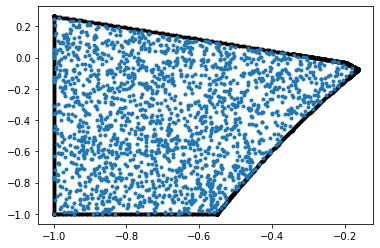

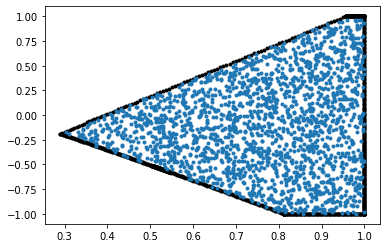

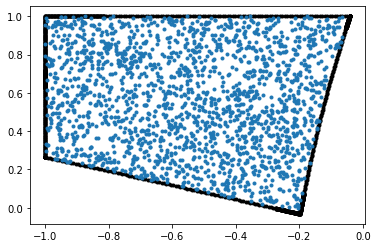

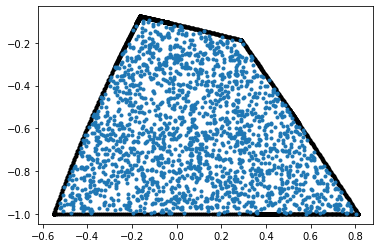

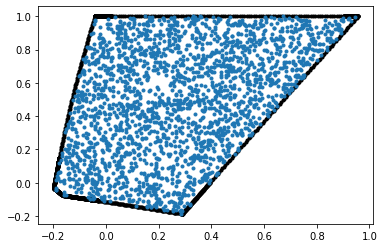

In [76]:
# test with overlapping cells
Y = np.array([[-0.94, -0.29],
               [ 0.98,  0.11],
               [-0.58,  0.69],
               [-0.13, -0.63],
               [ 0.16,  0.57]])
N = 5
psi = np.array([0.13, 0.19, 0.11, 0.27, 0.18])
#psi = np.ones(5)*1e-5
beta = 1

lag = make_laguerre(Y, psi, beta, k=100)

# check 3D power diagram
X = np.zeros((N,3))
X[:,0:2] = Y
X[:,2] = -psi
w = 2*psi**2
cells = make_power(X,w)
print("volume of power cells = {}".format(sum([volume_of_cell(c) for c in cells])))
print("area of 2D laguerre cells = {}".format(np.sum(compute_H_DH_from_laguerre(Y,beta,lag)[0])))


plt.figure()
plot_laguerre(lag)
plt.show()

plt.figure()
Z = 2*(np.random.rand(10000,2)-.5)
P = [[] for i in range(N)]
for z in Z:
    i = np.argmin(np.sqrt((z[0] - Y[:,0])**2 + (z[1] - Y[:,1])**2 + beta**2) + psi)
    P[i].append(z)
for i in range(N):
    p = np.array(P[i])
    plt.figure()
    plot_laguerre_cell(lag[i])
    plt.plot(p[:,0],p[:,1],'.')
    
for i in range(N):
    for j,curvesj in lag[i].items():
        for c in curvesj:
            for p in c:
                #print("ev:", np.sqrt(np.linalg.norm(p[0:2]-Y[i])**2 + beta**2) + psi[i])
                #print("z:", p[2])
                #print(p[2] - (np.sqrt(np.linalg.norm(p[0:2]-Y[i])**2 + beta**2) + psi[i]))
                quad = make_hyperboloid(Y[i], psi[i], beta)
                print(quad(p))

In [ ]:
# gradient descent

psi = 1*np.ones(N)
for i in range(10):
    h,dh = H_DH(psi)
    print("H(psi) = ", h)
    psi = psi + 0.1*(h-4/N)

In [ ]:
def area_of_cell(curves):
    if curves is None:
        return 0.0
    area = 0.0
    # compute area of cell i by integrating over the boundary
    # j is the number of the adjacent cell (negative number if adjacency 
    # is with the boundary)
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for k in range(crv.shape[0]-1):
                a = crv[k,0:2]
                b = crv[k+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
    return area

def areas_of_power_diagram_quadric_intersection(X,w,quad):
    cells = pypower.power_diagram(X,w)
    areas = [area_of_cell(intersect_cell_with_quadric(X,c,quad,20)) for c in cells]
    return np.array(areas)
 
N = 10
quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), 1)
X = np.random.rand(N,3)
w = np.zeros(N)
H = lambda w: areas_of_power_diagram_quadric_intersection(X,w,quad)
H(w)

In [ ]:

def enlarge(x):
    z = np.zeros(len(x)+1)
    z[1:] = x
    return z
x = opt.fsolve(lambda x: (H(enlarge(x)) - 4/N)[1:], np.zeros(N-1))
w = enlarge(x)

In [ ]:
# Oliker-Prussner
N = 10
X = np.random.rand(N,3)
w = np.zeros(N)
w[0] = 5
delta = 0.35
nu = 4*np.ones(N)/N

def H(w):
    return areas_of_power_diagram_quadric_intersection(X,w,quad)
def Hi(w,i):
    cells = pypower.power_diagram(X,w)
    return area_of_cell(intersect_cell_with_quadric(X,cells[i],quad,20))
def e(i):
    x = np.zeros(N)
    x[i] = 1
    return x
    
while delta>0.01:
    print("delta={}".format(delta))
    good = False
    while not good:
        good = True
        t = np.zeros(N)
        for i in range(1,N):
            if Hi(w,i) >= nu[i] - delta:
                continue
            f = lambda s: Hi(w+s*e(i),i) - nu[i]
            # cell i does not have enough mass: we need to increase w
            t[i] = opt.root_scalar(f, bracket=[0,10]).root
            good = False
        print(np.linalg.norm(H(w) - 4/N))
        w = w + t
    delta /= 2

In [ ]:
# check (visually) the computation of the intersection between a triangle and a quadric

def trisample(A, B, C,N):
    r1 = np.random.rand(N)
    r2 = np.random.rand(N)
    s1 = np.sqrt(r1)

    X = np.zeros((N,3))
    X[:,0] = A[0] * (1.0 - s1) + B[0] * (1.0 - r2) * s1 + C[0] * r2 * s1
    X[:,1] = A[1] * (1.0 - s1) + B[1] * (1.0 - r2) * s1 + C[1] * r2 * s1
    X[:,2] = A[2] * (1.0 - s1) + B[2] * (1.0 - r2) * s1 + C[2] * r2 * s1
    return X


def test_triangle():
    above = np.array([0,0,2])
    quad = make_quad(np.array([0,0]),0,1)
    v = np.random.rand(3)
    w = np.random.rand(3)
    
    X = trisample(above,v,w,1000)
    s = np.array([quad(x) for x in X]).flatten()
    plt.plot(X[s>0,0], X[s>0,1],'.r')
    plt.plot(X[s<0,0], X[s<0,1],'.b')

    curves = intersect_triangle_with_quadric(quad, v, w, above)
    for c in curves:
        plt.plot(c[:,0], c[:,1],'g', linewidth=4)
        
#test_triangle()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

quad = make_quad(np.array([0,0]),0,.1)

N= 5
X = np.random.rand(N,3)
w = np.zeros(N)
cells = make_power(X,w)

area = 0
plt.figure(figsize=(10,10))
for i in range(N):
    curves = intersect_cell_with_quadric(X,cells[i],quad,30)
    if curves is None:
        print("empty cell {}".format(i))
        continue
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for i in range(crv.shape[0]-1):
                a = crv[i,0:2]
                b = crv[i+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
            plt.plot(crv[:,0], crv[:,1], 'k')
print(area)

In [72]:
# test make_hyperboloid
# X=(x,y,z) is above the graph of (x,y) -> sqrt(|(x,y)-p|^2 + beta**2) + b_i
yi = np.random.rand(2)
bi = np.random.rand()
beta = 1
quad = make_hyperboloid(yi, bi, beta)
x = np.random.rand(2)
z = np.sqrt(np.linalg.norm(x-yi)**2 + beta**2) + bi
X = np.zeros(3)
X[0:2] = x
X[2] = z
print(quad(X))

#(z-b_i)^2 >= (x-px)^2 + (y-py)^2 + beta**2
print((z-bi)**2- (np.linalg.norm(x-yi)**2 + beta**2))

Q = np.array([-1,-1,1])
R = np.array([yi[0],yi[1],bi])
print(np.dot(Q*(X-R),X-R) - beta**2)
# <=> <Q(X-R)|(X-R)> - beta**2 >= 0 and z-b_i>=0
# with Q = diag(-1,-1,1), R = (px,py,bi)
# <=> <QX|X> + 2<QR|X> + <QR|R> - beta**2 >= 0
print(np.dot(Q*X,X) - 2*np.dot(Q*R,X) + np.dot(Q*R,R) - beta**2)



def make_hyperboloid(p, bi, beta):
    Q = np.array([-1,-1,1])
    R = np.array([p[0],p[1],bi])
    return Quadric(Q,b=2*Q*R,c=np.dot(Q*R,R) - beta**2,
                   truncating_plane=True,p=np.array([0,0,1]),d=-bi)


2.0916071135434198
-8.881784197001252e-16
-8.881784197001252e-16
-2.220446049250313e-16
